In [1]:
from jax_circuits import *
from scipy.stats import unitary_group
import matplotlib.pyplot as plt

import time
import pickle

from qiskit import transpile
from qiskit.quantum_info import Operator

from topology import *

from jax import custom_jvp, jvp, grad
from jax.scipy.optimize import minimize

key = random.PRNGKey(42)

# Simple function

In [32]:
def test_f(x):
    return (jnp.sin(x)**2+x**4-x**2+10*x).sum()

n_x = 100
test_primals = random.normal(random.PRNGKey(0), (n_x, ))
test_tangets = random.normal(random.PRNGKey(1), (n_x, ))

In [33]:
%%time
plain_hessian = plain_hessian_preconditioner(test_f, learning_rate=0.01)
angles_history_plain, loss_history_plain = gradient_descent_minimize(test_f, n_x, plain_hessian)

CPU times: user 6.01 s, sys: 2.41 s, total: 8.42 s
Wall time: 2.59 s


In [34]:
%%time
sparse_hessian = hessian_preconditioner(test_f, learning_rate=0.01)
angles_history_sparse, loss_history_sparse = gradient_descent_minimize(test_f, n_x, sparse_hessian)

CPU times: user 1.11 s, sys: 67.3 ms, total: 1.18 s
Wall time: 1.02 s


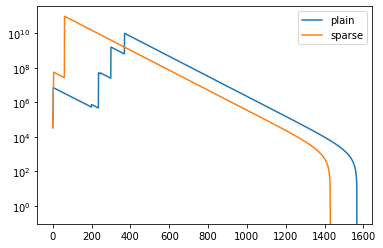

In [35]:
plt.plot(loss_history_plain, label='plain')
plt.plot(loss_history_sparse, label='sparse')
plt.legend()
plt.yscale('log')

# 2-qubit random unitary

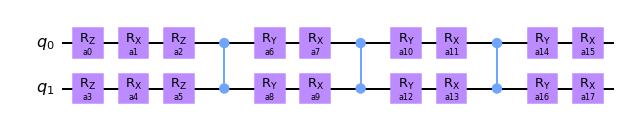

In [2]:
num_qubits = 2
depth = theoretical_lower_bound(num_qubits)

anz = Ansatz(num_qubits, 'cz', placements=fill_layers(sequ_layer(num_qubits), depth))
u_target = unitary_group.rvs(2**num_qubits, random_state=1)
anz.circuit().draw(output='mpl')

In [15]:
anz_cost = lambda angs: disc2(anz.unitary(angs), u_target)
initial_angles = random_angles(anz.num_angles, key=random.PRNGKey(42))

In [29]:
%%time
plain_hessian = plain_hessian_preconditioner(anz_cost, learning_rate=0.01)
angles_history_plain, loss_history_plain = gradient_descent_minimize(anz_cost, anz.num_angles, plain_hessian)

CPU times: user 24.7 s, sys: 10.2 s, total: 34.9 s
Wall time: 16.7 s


In [30]:
%%time
sparse_hessian = hessian_preconditioner(anz_cost, learning_rate=0.01)
angles_history_sparse, loss_history_sparse = gradient_descent_minimize(anz_cost, anz.num_angles, sparse_hessian)

CPU times: user 22.9 s, sys: 334 ms, total: 23.2 s
Wall time: 21.3 s


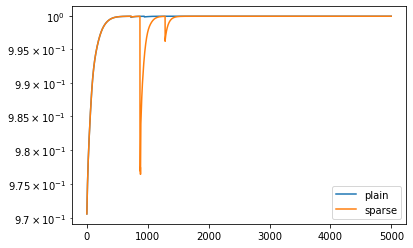

In [31]:
plt.plot(loss_history_plain, label='plain')
plt.plot(loss_history_sparse, label='sparse')
plt.legend()
plt.yscale('log')